In [46]:
#import wrds
#db = wrds.Connection(wrds_username='yanvo')

## The Data extraction

In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Get the list of all the SIC codes
if not os.path.exists('data/Siccodes12.txt'):

    with open('data/Siccodes12.txt', 'r') as file:
        lines = file.readlines()

    dic = {}

    for j in range(0, 10000):
        dic[j] = 12
        sic = lines[0].strip().split(" ")[0]
        i = 1
        while i < len(lines)-2:
            if lines[i].strip() == "":
                sic = lines[i+1].strip().split(" ")[0]
                i += 2
                continue
            else:
                a = lines[i].strip().split("-")
                if j in range(int(a[0]), int(a[1])+1):
                    dic[j] = sic
                i += 1

    df = pd.DataFrame(dic.items(), columns=['SIC', 'FF_12'])

    df.to_csv('48_Industries.csv', index=False)

In [49]:
if not os.path.exists('data/data.csv'):
    #---------------------------------------------
    # Risk Free Rate 
    #---------------------------------------------
    Rf = db.raw_sql("""select  mcaldt,tmytm 
            from crsp.tfz_mth_rf            
                where kytreasnox = 2000001 
            and mcaldt>='1964-01-01'
                and mcaldt<='2023-12-31'""", 
                date_cols=['mcaldt'])

    Rf['tmytm'] = Rf['tmytm']/12/100
    Rf = Rf.rename(columns={"mcaldt": "date", "tmytm": "rf"})

    #---------------------------------------------
    # Value Weighted Index Returns
    #---------------------------------------------
    Rm = db.raw_sql("""select  date,vwretd from crsp.msi 
                    where date>='1964-01-01' and date<='2023-12-31'
                    """, 
                    date_cols=['date'])

    Rm = Rm.rename(columns={'vwretd':'Rm'})

    #---------------------------------------------
    # Stock Returns
    #---------------------------------------------
    stock_data = db.raw_sql("""
                        select a.permno, a.date, 
                        b.shrcd, b.exchcd, b.siccd,
                        a.ret, a.shrout, a.prc
                        from crsp.msf as a
                        left join crsp.msenames as b
                        on a.permno=b.permno
                        and b.namedt<=a.date
                        and a.date<=b.nameendt
                        where a.date between '01/01/1964' and '12/31/2023'
                        and b.exchcd between 1 and 2
                        and b.shrcd between 10 and 11
                        """, 
                        date_cols=['date'])

    stock_data = stock_data.drop(['shrcd', 'exchcd'], axis=1)
    stock_data = stock_data.rename(columns={'ret':'Rn'})
    stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
    stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)

    #---------------------------------------------
    # Industry Definitions  and Returns 
    #---------------------------------------------
    Industry_Returns = pd.read_csv('data/12_Industry_Portfolios.txt', delimiter= '\s+', skiprows=11, nrows=1173, index_col=0)
    Industry_Returns = Industry_Returns.loc['196401':'202312']
    Industry_Returns.index = pd.to_datetime(Industry_Returns.index, format='%Y%m')
    Industry_Definitions = pd.read_csv('data/48_Industries.csv')
    Industry_Definitions = Industry_Definitions.rename(columns={'SIC':'siccd'})
    Industries = Industry_Returns.columns.tolist()
    Industry_Names = pd.DataFrame(Industries,index=np.arange(1,13)).reset_index()
    Industry_Names.columns=['Industry','Name']
    Industry_Returns = Industry_Returns.reset_index().rename(columns = {'index':'dateM'})
    Industry_Returns['dateM'] = pd.to_datetime(Industry_Returns['dateM'], format='%Y%m', errors='coerce') + pd.offsets.MonthEnd(0)

    #---------------------------------------------
    # Merge Data 
    #---------------------------------------------
    data = pd.merge(stock_data, Rf, on=['date'], how='left')
    data = pd.merge(data, Rm, on=['date'], how='left')
    data = pd.merge(data, Industry_Definitions[['siccd', 'FF_12']], on=['siccd'], how='left')
    #data['dateM'] = data['date'].astype('datetime64[M]')
    data['dateM'] = data['date']

    data = pd.merge(data, Industry_Returns, on=['dateM'], how='left')
    rf_array = np.array(data['rf'])
        
    data[Industries] = data[Industries]/100 - rf_array[:,np.newaxis]

    #---------------------------------------------
    # Define Variables and drop obs
    #---------------------------------------------
    data = data.sort_values(['permno','date'])
    data['mcap'] = np.abs(data['prc']) * data['shrout']
    data['mcap_l'] = data.groupby(['permno'])['mcap'].shift(1)
    data['Rn_f'] = data.groupby(['permno'])['Rn'].shift(-1)
    data['const'] = 1
    data['Rn_e'] = data['Rn'] - data['rf']
    data['Rm_e'] = data['Rm'] - data['rf']
    data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')
    data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e', 'FF_12']).copy()

    #---------------------------------------------
    data.to_csv('data/data.csv', index=False)

In [50]:
data = pd.read_csv('data/data.csv', sep=",")
data['date'] = pd.to_datetime(data['date'])

In [51]:
data.shape

(1281568, 29)

In [52]:
data.sample(5)

,permno,date,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,...,Utils,Shops,Hlth,Money,Other,Rn_f,const,Rn_e,Rm_e,w_m
789795,52767,1973-08-31,6711,-0.107143,1498.0,-3.125,4681.250,5243.000,0.007151,-0.029657,...,-0.028151,-0.048751,-0.076051,-0.030351,-0.030051,-0.040000,1,-0.114294,-0.036808,0.000007
1025908,75104,2001-01-31,4841,0.191277,138900.0,55.990,7777011.000,6528300.000,0.004023,0.039573,...,-0.111723,0.060277,-0.089123,-0.008923,0.010677,-0.098232,1,0.187254,0.035550,0.000608
1120748,80415,1999-05-28,3241,0.014134,19931.0,35.875,715024.625,705059.125,0.003683,-0.020708,...,NaN,NaN,NaN,NaN,NaN,-0.047387,1,0.010451,-0.024391,0.000067
187888,19852,1990-08-31,3714,-0.200000,4463.0,15.500,69176.500,86470.625,0.006240,-0.091903,...,-0.072440,-0.126940,-0.074040,-0.116140,-0.123040,-0.080645,1,-0.206240,-0.098143,0.000033
675905,46228,1968-06-28,1381,-0.047521,2445.0,28.750,70293.750,73961.250,0.004404,0.011527,...,NaN,NaN,NaN,NaN,NaN,-0.069565,1,-0.051925,0.007123,0.000117


## Betting against Beta strategy

In [53]:
# 0. Remove nans
bab_data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

# 1. Remove stocks with less than 60 observations
bab_data['N'] = bab_data.groupby(['permno'])['date'].transform('count')
bab_data = bab_data[bab_data['N']>60].copy()

# 2. Estimate Rolling Betas
cov_nm = bab_data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
#beta_n = (cov_nm.iloc[1::2,1].droplevel(2)/cov_nm.iloc[0::2,1].droplevel(2))
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
bab_data = pd.merge(bab_data, beta_n, on=['date', 'permno'], how='left')

# 4. Remove outliers
bab_data['beta'] = bab_data['beta'].clip(bab_data['beta'].quantile(0.05), bab_data['beta'].quantile(0.95))

In [54]:
# 1. Quintiles
q = 10
bab_data = bab_data.dropna(subset=['beta']).copy()
bab_data['beta_Q'] = bab_data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, q, labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
bab_data['vw_Q'] = bab_data['mcap'] / bab_data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. Value Weighted Portfolios
bab_data['beta_ret_vw'] = bab_data['vw_Q'] * bab_data['Rn']
ret_vw = bab_data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
vw_SR = vw_ret_mean / vw_ret_std * np.sqrt(12)

# 4. Equal-Weighted portfolios
ret_ew = bab_data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()
ew_SR = ew_ret_mean / ew_ret_std * np.sqrt(12)

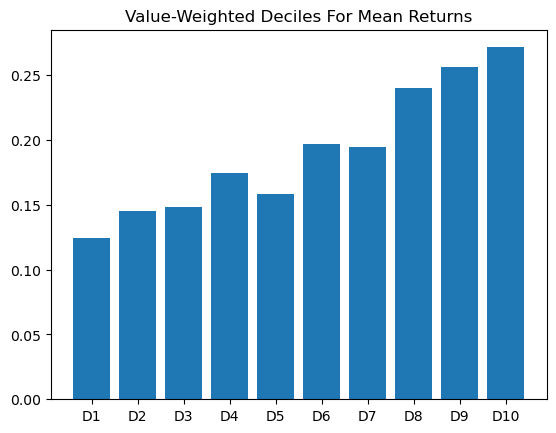

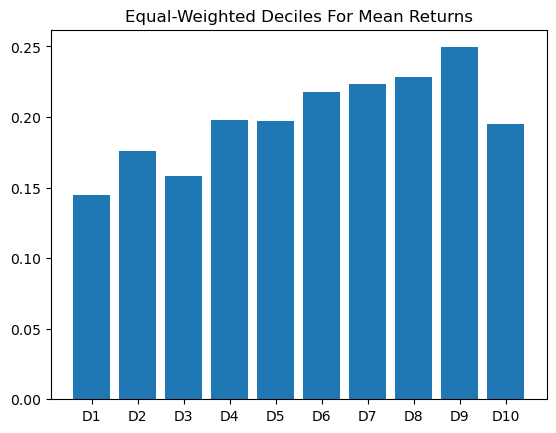

In [55]:
# 5. Plot Histogram for Mean Returns
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_ret_mean * 12)
plt.title('Value-Weighted Deciles For Mean Returns')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_ret_mean * 12),
plt.title('Equal-Weighted Deciles For Mean Returns')
plt.show()

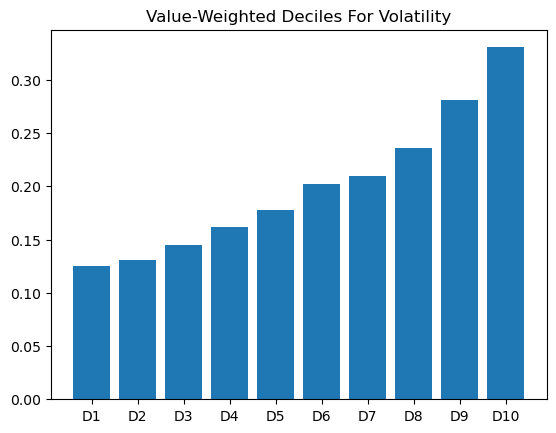

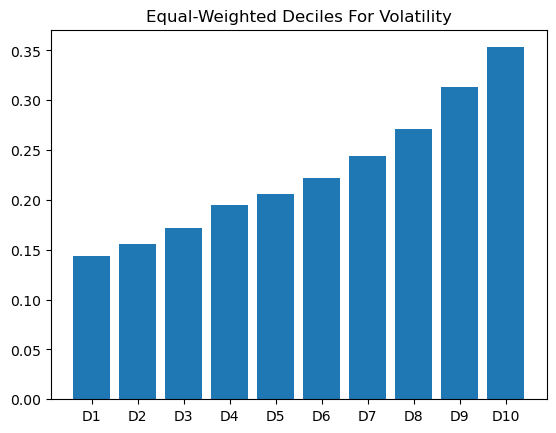

In [56]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles For Volatility')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles For Volatility')
plt.show()

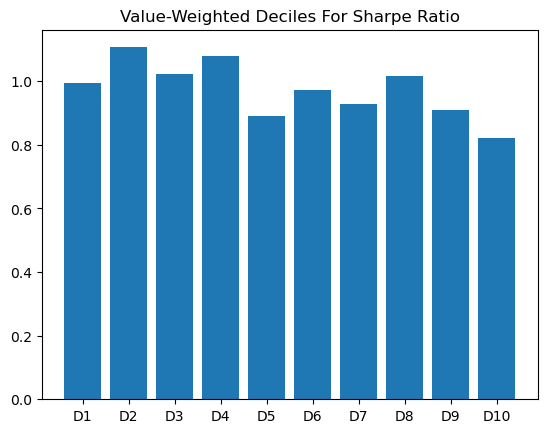

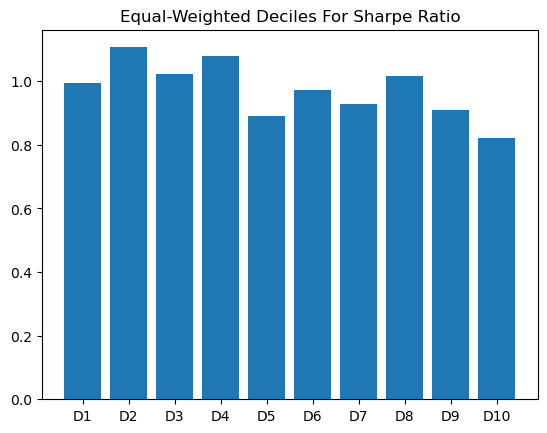

In [57]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_SR)
plt.title('Value-Weighted Deciles For Sharpe Ratio')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_SR),
plt.title('Equal-Weighted Deciles For Sharpe Ratio')
plt.show()

# TODO: Summarize our findings.  Is the evidence consistentwith the CAPM?

Value Weighted Portfolio: .

Equal Weighted Portfolio: .

In [58]:
# Weights
bab_data['z'] = bab_data.groupby('date')['beta'].transform(lambda x: x.rank())
bab_data['z_'] = bab_data['z'] - bab_data.groupby('date')['z'].transform('mean')
bab_data['k'] = np.abs(bab_data['z_'])
bab_data['k'] = 2/bab_data.groupby('date')['k'].transform('sum')
bab_data['w_H'] = bab_data['k'] * bab_data['z_'] * (bab_data['z_']>0) 
bab_data['w_L'] = -bab_data['k'] * bab_data['z_'] * (bab_data['z_']<0)
bab_data['w_BAB'] = bab_data['w_L'] - bab_data['w_H']

# Merge weights with data
data = pd.merge(data, bab_data[['date', 'permno', 'w_BAB']], on=['date', 'permno'], how='left')

# Weighted returns and beta
bab_data['beta_H'] = bab_data['w_H'] * bab_data['beta']
bab_data['beta_L'] = bab_data['w_L'] * bab_data['beta']
bab_data['R_H'] = bab_data['w_H'] * bab_data['Rn']
bab_data['R_L'] = bab_data['w_L'] * bab_data['Rn']
bab_data['R_H_e'] = bab_data['w_H'] * bab_data['Rn_e']
bab_data['R_L_e'] = bab_data['w_L'] * bab_data['Rn_e']
BAB = bab_data.groupby('date')[['R_H', 'R_L', 'R_H_e', 'R_L_e', 'beta_H', 'beta_L']].sum().reset_index()

print(BAB.shape)

# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']

(246, 7)


In [59]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB, bab_data[['date', 'Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1

# Alpha and Beta
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['const','Rm_e']]).fit()

Alpha_bab = OLS_Reg.params[0] * 12
idio_vol = (tmp['BAB2'] - OLS_Reg.predict()).std() * np.sqrt(12)
market_rp = tmp['Rm_e'].mean() * 12
market_vol = tmp['Rm_e'].std() * np.sqrt(12)
beta_bab = OLS_Reg.params[1]

print('Annualized Alpha of BAB factor:', Alpha_bab, "t-stat:", OLS_Reg.tvalues[0])
print('Mean of BAB factor:', tmp['BAB2'].mean() * 12)
print('Volatility of BAB factor:', tmp['BAB2'].std() * np.sqrt(12))
print('Sharpe Ratio of BAB factor:', tmp['BAB2'].mean()/tmp['BAB2'].std() * np.sqrt(12))
#print('Idiosyncatic volatility:', idio_vol)
#print('Beta BAB:', beta_bab)
#print('Market Risk Premium:', market_rp)
#print('Market Volatility:', market_vol)

Annualized Alpha of BAB factor: 0.06683019184882398 t-stat: 2.558994731390483
Mean of BAB factor: 0.10571367143001861
Volatility of BAB factor: 0.14348370946603067
Sharpe Ratio of BAB factor: 0.7367642767491035


## Momentum Strategy (Mom)

In [60]:
mom_data = data.sort_values(['permno', 'date']).reset_index(drop=True).copy()
mom_data['LN_Cret12'] = mom_data.groupby('permno').apply(lambda x: np.log(x.Rn + 1).rolling(11, closed='left').sum()).values

In [61]:
q = 10
mom_data['Momentum'] = mom_data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x, q, labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
mom_data['vw_mom_Q'] = mom_data['mcap'] / mom_data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. Value Weighted Portfolios
mom_data['mom_ret_vw'] = mom_data['vw_mom_Q'] * mom_data['Rn']
ret_vw = mom_data.groupby(['date', 'Momentum'])['mom_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['mom_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('Momentum')['mom_ret_vw'].std()
vw_SR = vw_ret_mean / vw_ret_std * np.sqrt(12)

# 4. Equal-Weighted portfolios
ret_ew = mom_data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()
ew_SR = ew_ret_mean / ew_ret_std * np.sqrt(12)

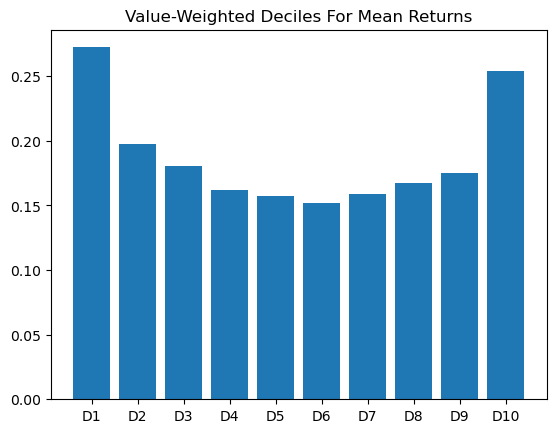

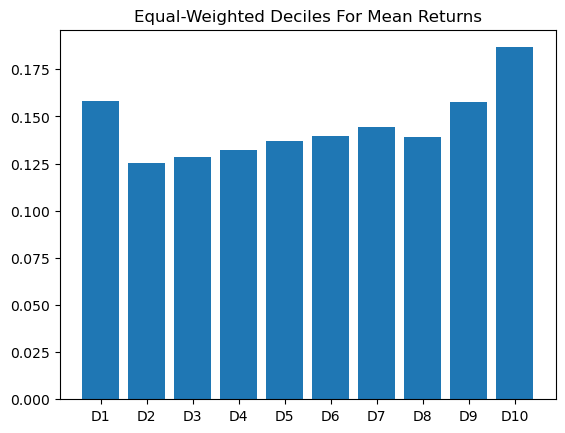

In [62]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_ret_mean * 12)
plt.title('Value-Weighted Deciles For Mean Returns')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles For Mean Returns')
plt.show()

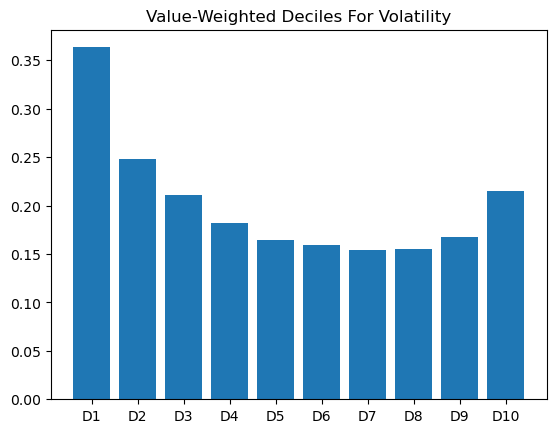

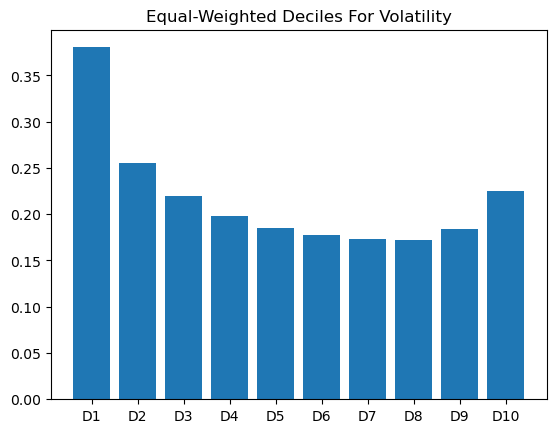

In [63]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles For Volatility')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles For Volatility')
plt.show()

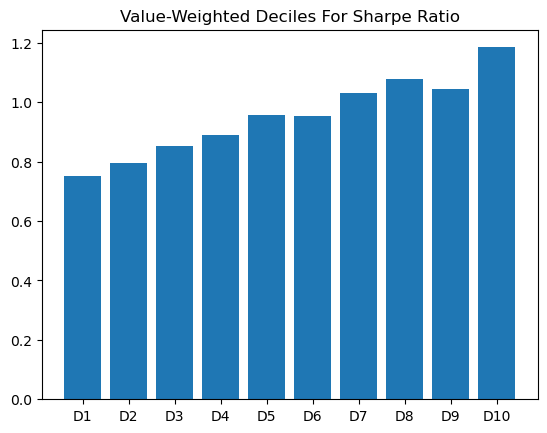

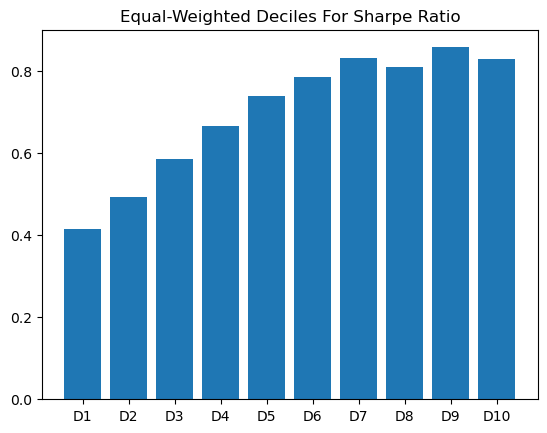

In [64]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_SR)
plt.title('Value-Weighted Deciles For Sharpe Ratio')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_SR)
plt.title('Equal-Weighted Deciles For Sharpe Ratio')
plt.show()

# TODO: Is the evidence consistent with the CAPM?

Value Weighted Portfolio: .

Equal Weighted Portfolio: .

In [65]:
mom_data['w_L'] = mom_data['Momentum'].isin([q - 1, q - 2, q - 3]) * mom_data['mcap']
mom_data['w_S'] = mom_data['Momentum'].isin([0, 1, 2]) * mom_data['mcap']
mom_data['w_L'] = mom_data['w_L']/mom_data.groupby(['date'])['w_L'].transform('sum')
mom_data['w_S'] = mom_data['w_S']/mom_data.groupby(['date'])['w_S'].transform('sum')
mom_data['w_Mom'] = mom_data['w_L'] - mom_data['w_S']

# Merge weights with data
data = pd.merge(data, mom_data[['date', 'permno', 'w_Mom']], on=['date', 'permno'], how='left')

Momentum = mom_data.groupby('date').apply(lambda x: np.sum(x['Rn_f'] * x['w_Mom'])).reset_index()
Momentum['date'] =  Momentum['date'] + pd.DateOffset(months=1)
Momentum.columns = ['date','Mom_ret']

In [66]:
mom_data['S_ret'] = mom_data['Rn_f'] * mom_data['w_S']

S_ret = mom_data.groupby('date').apply(lambda x: np.sum(x['S_ret'])).reset_index()
S_ret_mean = S_ret[0].mean()
S_ret_std = S_ret[0].std()
S_SR = S_ret_mean / S_ret_std * np.sqrt(12)

print('Mean of S factor:', S_ret_mean * 12)
print('Volatility of S factor:', S_ret_std * np.sqrt(12))
print('Sharpe Ratio of S factor:', S_SR)

Mean of S factor: 0.07714201358325944
Volatility of S factor: 0.2177878844486758
Sharpe Ratio of S factor: 0.35420709365235065


In [67]:
mom_data['L_ret'] = mom_data['Rn_f'] * mom_data['w_L']

L_ret = mom_data.groupby('date').apply(lambda x: np.sum(x['L_ret'])).reset_index()
L_ret_mean = L_ret[0].mean()
L_ret_std = L_ret[0].std()
L_SR = L_ret_mean / L_ret_std * np.sqrt(12)

print('Mean of L factor:', L_ret_mean * 12)
print('Volatility of L factor:', L_ret_std * np.sqrt(12))
print('Sharpe Ratio of L factor:', L_SR)

Mean of L factor: 0.12834075056200422
Volatility of L factor: 0.16410167148528676
Sharpe Ratio of L factor: 0.7820807027764562


In [68]:
mom_data['Mom_ret'] = mom_data['Rn_f'] * mom_data['w_Mom']

Mom_ret = mom_data.groupby('date').apply(lambda x: np.sum(x['Mom_ret'])).reset_index()
Mom_ret_mean = Mom_ret[0].mean()
Mom_ret_std = Mom_ret[0].std()
Mom_SR = Mom_ret_mean / Mom_ret_std * np.sqrt(12)

print('Mean of Mom factor:', Mom_ret_mean * 12)
print('Volatility of Mom factor:', Mom_ret_std * np.sqrt(12))
print('Sharpe Ratio of Mom factor:', Mom_SR)

Mean of Mom factor: 0.0511987369787448
Volatility of Mom factor: 0.1693761156467384
Sharpe Ratio of Mom factor: 0.30227837486560466


In [69]:
# Perform t-test
t_statistic, p_value = ttest_ind(Mom_ret_mean, 0)

if p_value < 0.05:
    print("The strategy has an average return that is statistically significantly different from zero.")
else:
    print("The strategy does not have an average return that is statistically significantly different from zero.")

The strategy does not have an average return that is statistically significantly different from zero.


In [70]:
# TODO: Repeat both tests for equal and value-weightedportfolios


## Idiosyncratic Volatility Strategy (IV)

In [71]:
# Step 1: Ensure at least 36 months of observations for each stock
iv_data = data.copy()
iv_data['N'] = iv_data.groupby(['permno'])['date'].transform('count')
iv_data = iv_data[iv_data['N'] >= 36].copy()

In [72]:
idiosyncratic_volatility = {}

if not os.path.exists('data/idio_volatility.csv'): 
    for permno, group in iv_data.groupby('permno'):
        rolling_data = group.set_index('date')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36)
        dic = {}
        for window in rolling_data:
            X = sm.add_constant(window[['Rm_e']])
            y = window['Rn_e']
            model = sm.OLS(y, X)
            results = model.fit()
            fitted_values = results.predict(X)
            idio_vol = (y - fitted_values).std()*np.sqrt(12)
            date = window.iloc[-1].name
            dic[date] = idio_vol 
        idiosyncratic_volatility[permno] = dic
    
    # transform the dictionary into a DataFrame
    idio_vol_df = pd.DataFrame(idiosyncratic_volatility).T.stack().reset_index().rename(columns={'level_0':'permno', 'level_1':'date', 0:'idio_vol'})
    # export the DataFrame to a csv file
    idio_vol_df.to_csv('data/idio_volatility.csv', index=False)

In [73]:
idio_vol_df = pd.read_csv('data/idio_volatility.csv')
idio_vol_df['date'] = pd.to_datetime(idio_vol_df['date'])

In [74]:
#merge idio_vol_df with data
iv_data = pd.merge(iv_data, idio_vol_df, on=['date', 'permno'], how='left')

# Step 3: Winsorize the volatility at 5th and 95th percentiles
iv_data['idio_vol'] = iv_data['idio_vol'].clip(iv_data['idio_vol'].quantile(0.05), iv_data['idio_vol'].quantile(0.95))

In [75]:
q = 10
iv_data['idio_vol_Q'] = iv_data.groupby('date')['idio_vol'].transform(lambda x: pd.qcut(x, q, labels=False, duplicates='drop'))

# 2. Market Weights within quintiles
iv_data['vw_idio_vol_Q'] = iv_data['mcap'] / iv_data.groupby(['date', 'idio_vol_Q'])['mcap'].transform('sum')

# 3. Value Weighted Portfolios
iv_data['idio_vol_ret_vw'] = iv_data['vw_idio_vol_Q'] * iv_data['Rn']
ret_vw = iv_data.groupby(['date', 'idio_vol_Q'])['idio_vol_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('idio_vol_Q')['idio_vol_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('idio_vol_Q')['idio_vol_ret_vw'].std()
vw_SR = vw_ret_mean / vw_ret_std * np.sqrt(12)

# 4. Equal-Weighted portfolios
ret_ew = iv_data.groupby(['date', 'idio_vol_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('idio_vol_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('idio_vol_Q')['Rn'].std()
ew_SR = ew_ret_mean / ew_ret_std * np.sqrt(12)

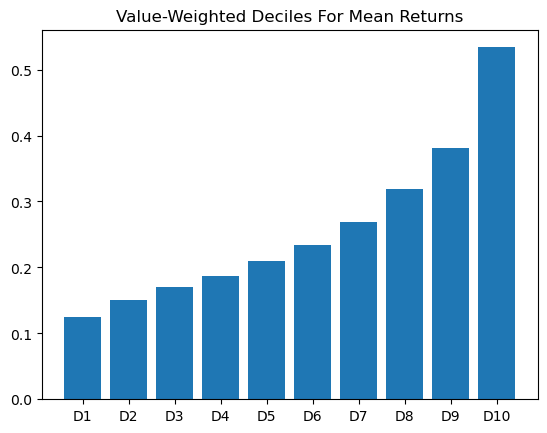

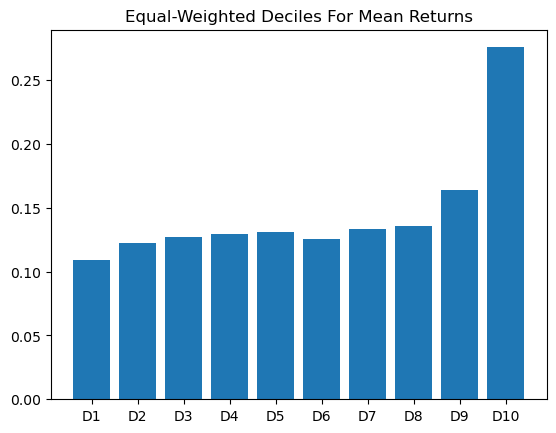

In [76]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_ret_mean * 12)
plt.title('Value-Weighted Deciles For Mean Returns')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles For Mean Returns')
plt.show()

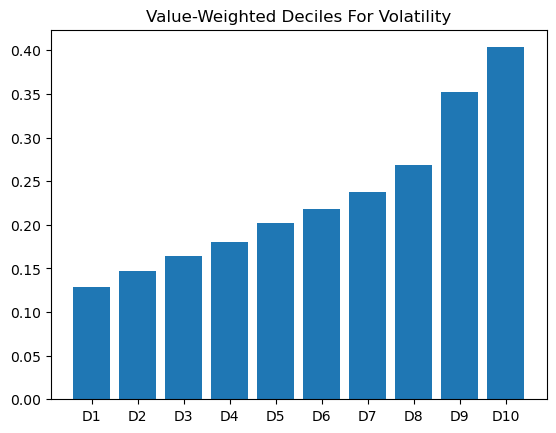

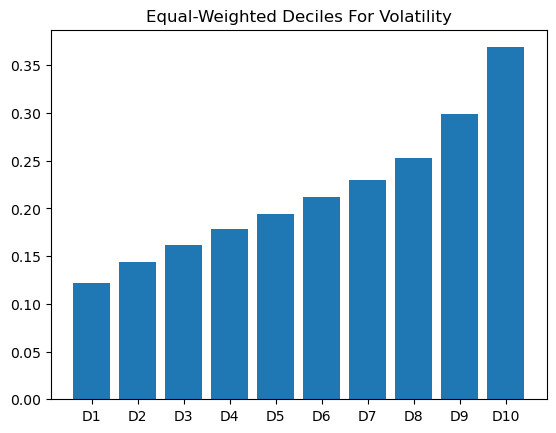

In [77]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles For Volatility')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles For Volatility')
plt.show()

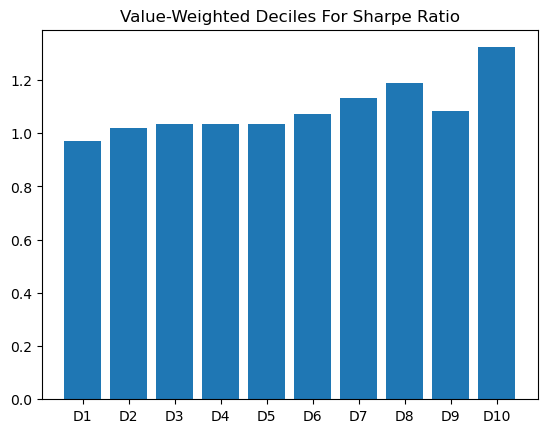

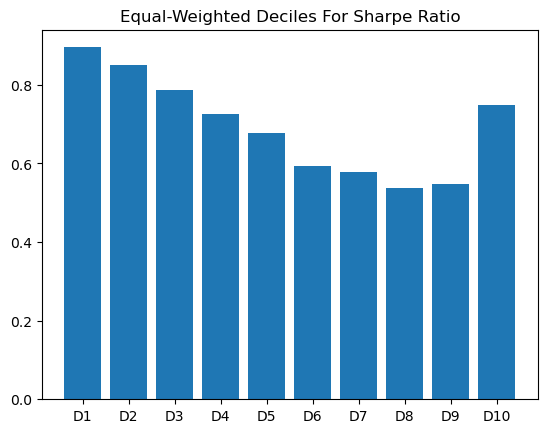

In [78]:
# 5. Plot Histogram
plt.bar(['D' + str(x) for x in np.arange(1, 11)], vw_SR)
plt.title('Value-Weighted Deciles For Sharpe Ratio')
plt.show()
plt.bar(['D' + str(x) for x in np.arange(1, 11)], ew_SR)
plt.title('Equal-Weighted Deciles For Sharpe Ratio')
plt.show()

# TODO: Is the evidence consistent with the CAPM?

Value Weighted Portfolio: .

Equal Weighted Portfolio: .

In [79]:
iv_data['w_L_idio_vol'] = iv_data['idio_vol_Q'].isin([q - 1, q - 2, q - 3]) * iv_data['mcap']
iv_data['w_S_idio_vol'] = iv_data['idio_vol_Q'].isin([0, 1, 2]) * iv_data['mcap']
iv_data['w_L_idio_vol'] = iv_data['w_L_idio_vol']/iv_data.groupby(['date'])['w_L_idio_vol'].transform('sum')
iv_data['w_S_idio_vol'] = iv_data['w_S_idio_vol']/iv_data.groupby(['date'])['w_S_idio_vol'].transform('sum')
iv_data['w_idio_vol'] = iv_data['w_L_idio_vol'] - iv_data['w_S_idio_vol']

# Merge weights with data
data = pd.merge(data, iv_data[['date', 'permno', 'w_idio_vol']], on=['date', 'permno'], how='left')

IdioVol = iv_data.groupby('date').apply(lambda x: np.sum(x['Rn_f'] * x['w_idio_vol'])).reset_index()
IdioVol['date'] =  IdioVol['date'] + pd.DateOffset(months=1)
IdioVol.columns = ['date', 'Idio_vol_ret']

In [80]:
iv_data['S_ret_idio_vol'] = iv_data['Rn_f'] * iv_data['w_S_idio_vol']

S_ret = iv_data.groupby('date').apply(lambda x: np.sum(x['S_ret_idio_vol'])).reset_index()
S_ret_mean = S_ret[0].mean()
S_ret_std = S_ret[0].std()
S_SR = S_ret_mean / S_ret_std * np.sqrt(12)

print('Mean of S factor:', S_ret_mean * 12)
print('Volatility of S factor:', S_ret_std * np.sqrt(12))
print('Sharpe Ratio of S factor:', S_SR)

Mean of S factor: 0.10393997707147531
Volatility of S factor: 0.13680490786171462
Sharpe Ratio of S factor: 0.7597678964598266


In [81]:
iv_data['L_ret_idio_vol'] = iv_data['Rn_f'] * iv_data['w_L_idio_vol']

L_ret = iv_data.groupby('date').apply(lambda x: np.sum(x['L_ret_idio_vol'])).reset_index()
L_ret_mean = L_ret[0].mean()
L_ret_std = L_ret[0].std()
L_SR = L_ret_mean / L_ret_std * np.sqrt(12)

print('Mean of L factor:', L_ret_mean * 12)
print('Volatility of L factor:', L_ret_std * np.sqrt(12))
print('Sharpe Ratio of L factor:', L_SR)

Mean of L factor: 0.09887379620598977
Volatility of L factor: 0.2614940994925156
Sharpe Ratio of L factor: 0.3781110028787463


In [82]:
iv_data['idio_vol_ret'] = iv_data['Rn_f'] * iv_data['w_idio_vol']

Idio_vol_ret = iv_data.groupby('date').apply(lambda x: np.sum(x['idio_vol_ret'])).reset_index()
Idio_vol_ret_mean = Idio_vol_ret[0].mean()
Idio_vol_ret_std = Idio_vol_ret[0].std()
Idio_vol_SR = Idio_vol_ret_mean / Idio_vol_ret_std * np.sqrt(12)

print('Mean of Idiosyncratic Volatility factor:', Idio_vol_ret_mean * 12)
print('Volatility of Idiosyncratic Volatility factor:', Idio_vol_ret_std * np.sqrt(12))
print('Sharpe Ratio of Idiosyncratic Volatility factor:', Idio_vol_SR)

Mean of Idiosyncratic Volatility factor: -0.0037343627785820918
Volatility of Idiosyncratic Volatility factor: 0.18424858209744907
Sharpe Ratio of Idiosyncratic Volatility factor: -0.02026806793339113


In [83]:
# Perform t-test
t_statistic, p_value = ttest_ind(Idio_vol_ret_mean, 0)

if p_value < 0.05:
    print("The strategy has an average return that is statistically significantly different from zero.")
else:
    print("The strategy does not have an average return that is statistically significantly different from zero.")

The strategy does not have an average return that is statistically significantly different from zero.


In [84]:
# TODO: Repeat both tests for equal and value-weightedportfolios


# TODO: How do your results differ from Ang, Hodrick, Xing, and Zhang (2006; table VI page 285) and what may be the explanation for the difference?

## Optimal Fund Portfolio Return (STRAT)

In [85]:
STRAT = pd.merge(Momentum, IdioVol, on=['date'], how='left')
STRAT = pd.merge(STRAT, BAB, on=['date'], how='left')
STRAT = STRAT[['date', 'Mom_ret', 'Idio_vol_ret', 'BAB2']]
STRAT['year'] = STRAT['date'].dt.year

target_vol = 0.1

### Equal weight the strategies

In [86]:
# compute equal weighted returns
STRAT['ew_strat_ret'] = (STRAT[['Mom_ret', 'Idio_vol_ret', 'BAB2']].sum(axis=1) /
                         STRAT[['Mom_ret', 'Idio_vol_ret', 'BAB2']].notna().sum(axis=1))

# compute the average annual volatility for the equal weighted strategy
ew_start_vol = STRAT['ew_strat_ret'].groupby(STRAT['year']).std().mean() * np.sqrt(12)
ew_c = np.sqrt(target_vol**2 / ew_start_vol**2)

print(ew_c)

1.0508245291270282


In [90]:
ew_start_vol

0.09516336669745894

In [94]:
FUND = pd.merge(STRAT, data[["date", "rf"]], on=['date'], how='left')
FUND['ew_fund_ret'] = FUND['rf'] + ew_c * FUND['ew_strat_ret']

In [95]:
ew_fund_ret_mean = FUND['ew_fund_ret'].mean()
ew_fund_ret_std = FUND['ew_fund_ret'].std()
ew_fund_SR = ew_fund_ret_mean / ew_fund_ret_std * np.sqrt(12)

In [96]:
print('Mean of equal-weighted strategy fund:', ew_fund_ret_mean * 12)
print('Volatility of equal-weighted strategy fund:', ew_fund_ret_std * np.sqrt(12))
print('Sharpe Ratio of equal-weighted strategy fund:', ew_fund_SR)

Mean of equal-weighted strategy fund: 0.13315389510705092
Volatility of equal-weighted strategy fund: 0.10435004243886115
Sharpe Ratio of equal-weighted strategy fund: 1.276031058493014


### Risk-Parity based on the rolling window estimate of the strategy returns volatilities

In [97]:
bab_ret_vol = STRAT['BAB2'].std() * np.sqrt(12)
momentum_ret_vol = STRAT['Mom_ret'].std() * np.sqrt(12)
idio_vol_ret_vol = STRAT['Idio_vol_ret'].std() * np.sqrt(12)

rp_w_bab = 1 / bab_ret_vol
rp_w_momentum = 1 / momentum_ret_vol
rp_w_idio_vol = 1 / idio_vol_ret_vol

inverse_vol_sum = rp_w_bab + rp_w_momentum + rp_w_idio_vol

rp_w_bab = rp_w_bab / inverse_vol_sum
rp_w_momentum = rp_w_momentum / inverse_vol_sum
rp_w_idio_vol = rp_w_idio_vol / inverse_vol_sum

rp_w_bab = rp_w_bab
rp_w_momentum = rp_w_momentum
rp_w_idio_vol = rp_w_idio_vol

STRAT['rp_strat_ret'] = (rp_w_bab * STRAT['BAB2'].fillna(0) +
                         rp_w_momentum * STRAT['Mom_ret'].fillna(0) +
                         rp_w_idio_vol * STRAT['Idio_vol_ret'].fillna(0))

# compute the average annual volatility for the equal weighted strategy
rp_start_vol = STRAT['rp_strat_ret'].groupby(STRAT['year']).std().mean() * np.sqrt(12)
rp_c = np.sqrt(target_vol**2 / ew_start_vol**2)

print(rp_c)

1.0508245291270282


In [98]:
STRAT

,date,Mom_ret,Idio_vol_ret,BAB2,year,ew_strat_ret,rp_strat_ret
0,1964-03-28,0.000000,0.000000,NaN,1964,0.000000,0.000000
1,1964-04-30,0.000000,0.000000,NaN,1964,0.000000,0.000000
2,1964-05-30,0.000000,0.000000,NaN,1964,0.000000,0.000000
3,1964-06-28,0.000000,0.000000,NaN,1964,0.000000,0.000000
4,1964-07-30,0.000000,0.000000,NaN,1964,0.000000,0.000000
...,...,...,...,...,...,...,...
713,2023-09-30,0.011751,0.016672,NaN,2023,0.014211,0.008735
714,2023-10-29,-0.016366,-0.032661,NaN,2023,-0.024514,-0.014966
715,2023-11-30,0.027116,-0.030541,0.032016,2023,0.009530,0.011883
716,2023-12-30,-0.057142,0.030978,NaN,2023,-0.013082,-0.009247


In [99]:
FUND = pd.merge(FUND, STRAT[['date', 'rp_strat_ret']], on=['date'], how='left')
FUND['rp_fund_ret'] = FUND['rf'] + rp_c * FUND['rp_strat_ret']

In [100]:
rp_fund_ret_mean = FUND['rp_fund_ret'].mean()
rp_fund_ret_std = FUND['rp_fund_ret'].std()
rp_fund_SR = rp_fund_ret_mean / rp_fund_ret_std * np.sqrt(12)

In [101]:
print('Mean of risk-parity strategy fund:', rp_fund_ret_mean * 12)
print('Volatility of risk-parity strategy fund:', rp_fund_ret_std * np.sqrt(12))
print('Sharpe Ratio of risk-parity strategy fund:', rp_fund_SR)

Mean of risk-parity strategy fund: 0.12739086578389247
Volatility of risk-parity strategy fund: 0.09652040472253319
Sharpe Ratio of risk-parity strategy fund: 1.3198335227675686


In [102]:
data['w_strat'] = data['w_BAB'] * rp_w_bab + data['w_Mom'] * rp_w_momentum + data['w_idio_vol'] * rp_w_idio_vol

### Mean-variance optimal combination based on the rolling window mean and covariance matrix of the strategy returns

## Performance and risk analysis for the Fund strategy

### Performance against the industry portfolio

In [103]:
Industries = [
    'NoDur',
    'Durbl',
    'Manuf',
    'Enrgy',
    'Chems',
    'BusEq',
    'Telcm',
    'Utils',
    'Shops',
    'Hlth',
    'Money',
    'Other'
    ]

# Merge
tmp = pd.merge(FUND, data[['date', 'Rm_e'] + Industries].drop_duplicates(), on='date', how='left')
tmp['const'] = 1
tmp = tmp.dropna()

# Industry Exposure
RegOLS = sm.OLS(tmp['rp_fund_ret'], tmp[['const'] + Industries + FF]).fit()
print(pd.concat([RegOLS.params, RegOLS.tvalues], axis=1).rename(columns={0:'Coef', 1:'t-stat'}))
print("R²:", RegOLS.rsquared)

NameError: name 'FF' is not defined

### Performance against the Fama-French 5 factors

In [ ]:
#read fama french data
FF = pd.read_csv('data/F-F_5.csv', sep=",", skiprows=3, index_col=0)
FF = FF.loc['196401':'202312']
FF.index = pd.to_datetime(FF.index, format='%Y%m')
FF = FF.astype(float)
FF['year'] = FF.index.year
FF['month'] = FF.index.month

FUND['year'] = FUND['date'].dt.year
FUND['month'] = FUND['date'].dt.month

# regress the momentum returns on the Fama-French factors
tmp = pd.merge(FUND, FF, on=['year', 'month'], how='left')
tmp = tmp.dropna()
tmp['const'] = 1

RegOLS = sm.OLS(tmp['rp_fund_ret'], tmp[['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]).fit()
print(pd.concat([RegOLS.params, RegOLS.tvalues], axis=1).rename(columns={0:'Coef', 1:'t-stat'}))
print("R²:", RegOLS.rsquared)

            Coef    t-stat
const   0.006552  2.420272
Mkt-RF  0.002954  5.283059
SMB     0.004735  4.395238
HML    -0.000713 -0.497209
RMW     0.001525  1.289754
CMA     0.001533  0.780690
R²: 0.5652856963825502


In [104]:
data.columns

Index(['permno', 'date', 'siccd', 'Rn', 'shrout', 'prc', 'mcap', 'mcap_l',
       'rf', 'Rm', 'FF_12', 'dateM', 'NoDur', 'Durbl', 'Manuf', 'Enrgy',
       'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other',
       'Rn_f', 'const', 'Rn_e', 'Rm_e', 'w_m', 'w_BAB', 'w_Mom', 'w_idio_vol',
       'w_strat'],
      dtype='object')

In [105]:
# Compute market beta for each stock
Parameters = data.groupby('permno').apply(lambda x: sm.OLS(x['Rn_e'], x[['const', 'Rm_e']]).fit().params).reset_index()
Parameters.columns=['permno', 'alpha', 'beta_Mkt']
tmp = pd.merge(data[['date', 'permno', 'w_strat', 'Rn_e', 'FF_12']], Parameters[['permno', 'beta_Mkt']], on=['permno'], how='left')
tmp['beta_Mkt'] = tmp['beta_Mkt'].clip(-2, 2)

# Industry Exposures as Dummy
tmp[Industries] = pd.get_dummies(tmp['FF_12']).replace({True: 1, False: 0})

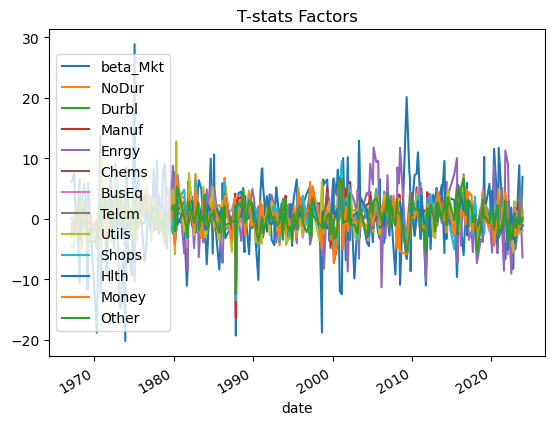

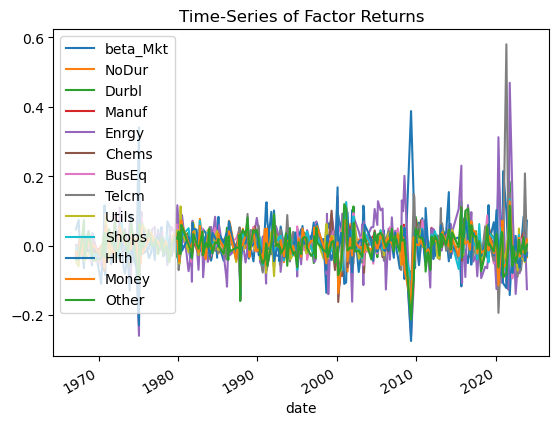

          Mean T-stats  Mean Abs T-stats
beta_Mkt      0.346350          4.827743
NoDur         0.323005          1.841895
Durbl         0.201581          1.494782
Manuf         0.430925          2.155717
Enrgy         0.609446          3.395314
Chems         0.254330          1.620890
BusEq         0.325842          1.640469
Telcm         0.213817          1.210590
Utils         0.375957          2.458410
Shops         0.392220          1.825769
Hlth          0.244591          1.645193
Money         0.286624          2.028475
Other         0.304820          1.924955


In [ ]:
# Estimate Factor
Factors = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'], x[['beta_Mkt'] + Industries]).fit().params)

Factors_tstats = tmp.groupby(['date']).apply(lambda x: sm.OLS(x['Rn_e'], x[['beta_Mkt'] + Industries]).fit().tvalues)

# Plot T-stats
Factors_tstats.plot()
plt.title('T-stats Factors')
plt.show()
Factors.plot()
plt.title('Time-Series of Factor Returns')
plt.show()
print(pd.concat([Factors_tstats.mean(), np.abs(Factors_tstats).mean()], axis=1).rename(columns={0:'Mean T-stats', 1:'Mean Abs T-stats'}))

In [ ]:
Exposures = tmp[['date', 'w_Mom', 'beta_Mkt'] + Industries].copy()
Exposures[Industries] = Exposures[Industries] * Exposures['w_Mom'].to_numpy()[:, np.newaxis]
Exposures['beta_Mkt'] = Exposures['w_Mom'] * Exposures['beta_Mkt']
Exposures = Exposures.groupby('date')[['beta_Mkt'] + Industries].sum()

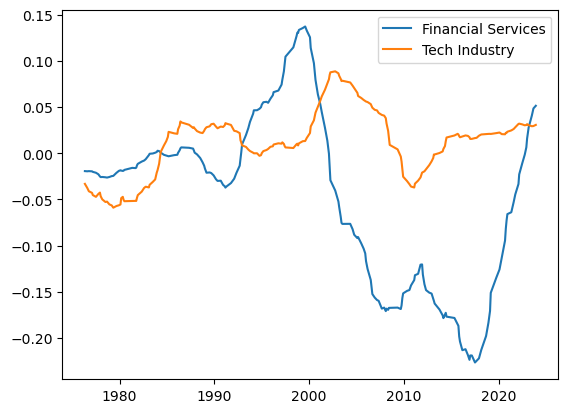

In [ ]:
# Plot Exposure to all industries
''' plt.plot(Exposures)
plt.legend(Exposures.columns)
plt.show()'''


# Plot Exposure to Tech and Finance
plt.plot(Exposures['Money'].rolling(36).mean())
plt.plot(Exposures['BusEq'].rolling(36).mean())
plt.legend(['Financial Services', 'Tech Industry'])
plt.show()

In [ ]:
# Hedge Portfolio Return
Hedge_Return = Factors * Exposures.rename(columns={'beta_Mkt':'Rm_e'})
Hedge_Return = Hedge_Return.sum(axis=1)

STRAT_hedge = STRAT.set_index('date') - Hedge_Return.to_numpy()[:, np.newaxis]
print('Industry-Hedged Return:', STRAT_hedge.mean() * 12)
print('Industry-Hedged Volatility:', STRAT_hedge.std() * np.sqrt(12))
print('Industry-Hedged Sharpe Ratio:', STRAT_hedge.mean()/STRAT_hedge.std() * np.sqrt(12))

Momentum-Hedged Return:  Mom_ret   -0.006836
dtype: float64
Momentum-Hedged Std:  Mom_ret    0.135733
dtype: float64
Momentum-Hedged Sharpe:  Mom_ret   -0.050367
dtype: float64


## Industry neutral strategy

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


def compute_bab_strategy(industry_data):
    # Compute the market beta for each stock using rolling window regression
    cov_nm = industry_data.set_index('date').groupby('permno')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36).cov()
    beta_n = (cov_nm.iloc[0::2, 1].droplevel(2) / cov_nm.iloc[1::2, 1].droplevel(2)).dropna().reset_index().rename(columns={'Rm_e': 'beta'})
    beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
    industry_data = pd.merge(industry_data, beta_n, on=['date', 'permno'], how='left')
    industry_data['beta'] = industry_data['beta'].clip(industry_data['beta'].quantile(0.05), industry_data['beta'].quantile(0.95))
    industry_data['z'] = industry_data.groupby('date')['beta'].transform(lambda x: x.rank())
    industry_data['z_'] = industry_data['z'] - industry_data.groupby('date')['z'].transform('mean')
    industry_data['k'] = 2 / industry_data.groupby('date')['z_'].transform('sum')
    industry_data['w_H'] = industry_data['k'] * industry_data['z_'] * (industry_data['z_'] > 0)
    industry_data['w_L'] = -industry_data['k'] * industry_data['z_'] * (industry_data['z_'] < 0)
    industry_data['R_H'] = industry_data['w_H'] * industry_data['Rn']
    industry_data['R_L'] = industry_data['w_L'] * industry_data['Rn']
    BAB = industry_data.groupby('date')[['R_H', 'R_L']].sum().reset_index()
    BAB['BAB'] = BAB['R_L'] - BAB['R_H']
    return BAB['BAB'].values

def compute_iv_strategy(industry_data):
    # Compute the idiosyncratic volatility for each stock
    idiosyncratic_volatility = {}
    for permno, group in industry_data.groupby('permno'):
        rolling_data = group.set_index('date')[['Rn_e', 'Rm_e']].rolling(60, min_periods=36)
        dic = {}
        for window in rolling_data:
            X = sm.add_constant(window[['Rm_e']])
            y = window['Rn_e']
            model = sm.OLS(y, X)
            results = model.fit()
            fitted_values = results.predict(X)
            idio_vol = (y - fitted_values).std() * np.sqrt(12)
            date = window.iloc[-1].name
            dic[date] = idio_vol
        idiosyncratic_volatility[permno] = dic
    idio_vol_df = pd.DataFrame(idiosyncratic_volatility).T.stack().reset_index().rename(columns={'level_0': 'permno', 'level_1': 'date', 0: 'idio_vol'})
    idio_vol_df['date'] = pd.to_datetime(idio_vol_df['date'])
    industry_data = pd.merge(industry_data, idio_vol_df, on=['date', 'permno'], how='left')
    industry_data['idio_vol'] = industry_data['idio_vol'].clip(industry_data['idio_vol'].quantile(0.05), industry_data['idio_vol'].quantile(0.95))
    industry_data['idio_vol_rank'] = industry_data.groupby('date')['idio_vol'].transform(lambda x: x.rank())
    industry_data['idio_vol_w'] = industry_data.groupby('date')['idio_vol_rank'].transform(lambda x: x / x.sum())
    industry_data['IV'] = industry_data['idio_vol_w'] * industry_data['Rn']
    IV = industry_data.groupby('date')['IV'].sum().reset_index()
    return IV['IV'].values

def compute_mom_strategy(industry_data):
    # Compute the momentum (cumulative return over past 11 months)
    industry_data = industry_data.sort_values(['permno', 'date'])
    industry_data['LN_Cret12'] = industry_data.groupby('permno').apply(lambda x: np.log(x.Rn + 1).rolling(11, closed='left').sum()).values
    industry_data['momentum_rank'] = industry_data.groupby('date')['LN_Cret12'].transform(lambda x: x.rank())
    industry_data['momentum_w'] = industry_data.groupby('date')['momentum_rank'].transform(lambda x: x / x.sum())
    industry_data['MOM'] = industry_data['momentum_w'] * industry_data['Rn']
    MOM = industry_data.groupby('date')['MOM'].sum().reset_index()
    return MOM['MOM'].values

# Compute risk parity weights
def compute_risk_parity_weights(returns):
    volatilities = returns.std(axis=1)
    inv_vol = 1 / volatilities
    weights = inv_vol / inv_vol.sum()
    return weights

# Target a specific volatility
def target_volatility(weights, returns, target_vol=0.10):
    portfolio_return = np.dot(weights, returns)
    current_vol = portfolio_return.std() * np.sqrt(12)  # annualize the monthly volatility
    scale_factor = target_vol / current_vol
    return weights * scale_factor

# Dictionary to hold strategy returns for each industry
industry_returns = {}

for industry in range(1, 13):
    print(f"Computing strategy returns for industry {industry}")
    industry_data = data[data['FF_12'] == industry]
    print(industry_data)
    BaBi = compute_bab_strategy(industry_data)
    print(BaBi)
    IVi = compute_iv_strategy(industry_data)
    print(IVi)
    MoMi = compute_mom_strategy(industry_data)
    print(MoMi)
    combined_returns = np.vstack([BaBi, IVi, MoMi])
    risk_parity_weights = compute_risk_parity_weights(combined_returns)
    adjusted_weights = target_volatility(risk_parity_weights, combined_returns)
    industry_returns[industry] = np.dot(adjusted_weights, combined_returns)

industry_returns_df = pd.DataFrame(industry_returns)

# (b) Combine Industry Strategies
equal_weighted_strategy = industry_returns_df.mean(axis=1)

mean_return = equal_weighted_strategy.mean() * 12  # annualize
std_return = equal_weighted_strategy.std() * np.sqrt(12)  # annualize
sharpe_ratio = mean_return / std_return

print("Industry-Neutral STRAT Mean Return:", mean_return)
print("Industry-Neutral STRAT Standard Deviation:", std_return)
print("Industry-Neutral STRAT Sharpe Ratio:", sharpe_ratio)


